## Spice and T section plots, MY COPY

Here we consider the spice variable. 

The version 2 finalizes the figures that will be put into the paper. 

The figures will include:  
a) Depth-along track distance (with time represented on 2nd axis) plot of temperature, with density overlaid.  
b) Mean-depth along track distance plot of spice.  
c) Marking the time on these panels will allow us to remove the sections from the plots with SSH. 
d) See if adding points to show dive locations helps to show sampling frequency. 


In [1]:
import numpy as np
import xarray as xr

from cmocean import cm as cmo

import gsw

import matplotlib.pyplot as plt

In [2]:
plt.style.use('seaborn-colorblind')
plt.rcParams['font.size'] = 8

In [3]:
# Pick 659 or 660 here 
glid_num = '659'
ds_rho = xr.open_dataset('sg_'+glid_num+'_iso_grid.nc')
ds_z   = xr.open_dataset('sg_'+glid_num+'_4m_binned.nc')

#### Convert to along track distance axis from dives

In [4]:
import extra_funcs as xf

In [5]:
# interpolate to dsistance axis
ds_z_dist = xr.merge( [xf.interp_distance(ds_z.where(~np.isnan(ds_z.longitude.mean('ctd_pressure')), drop=True), 'CT'), 
                           xf.interp_distance(ds_z.where(~np.isnan(ds_z.longitude.mean('ctd_pressure')), drop=True), 'SA'),
                           xf.interp_distance(ds_z.where(~np.isnan(ds_z.longitude.mean('ctd_pressure')), drop=True), 'Oxygen'),
                           xf.interp_distance(ds_z.where(~np.isnan(ds_z.longitude.mean('ctd_pressure')), drop=True), 'sigma0')] )

NameError: name 'gt' is not defined

In [6]:
ds_rho_dist = xr.merge( [xf.interp_distance(ds_rho.where(~np.isnan(ds_rho.longitude.mean('rho_grid')), drop=True), 'CT', 'rho_grid'), 
                             xf.interp_distance(ds_rho.where(~np.isnan(ds_rho.longitude.mean('rho_grid')), drop=True), 'SA', 'rho_grid'), 
                             xf.interp_distance(ds_rho.where(~np.isnan(ds_rho.longitude.mean('rho_grid')), drop=True), 'Oxygen', 'rho_grid'), 
                             xf.interp_distance(ds_rho.where(~np.isnan(ds_rho.longitude.mean('rho_grid')), drop=True), 'ctd_pressure', 'rho_grid')] )

### Estimate the spice and AOU

In [7]:
alpha = gsw.alpha(ds_rho_dist.SA, ds_rho_dist.CT, ds_rho_dist.ctd_pressure)

dCT = ds_rho_dist.CT - ds_rho_dist.CT.mean('distance')
ds_rho_dist['Spice']= 2*1000*alpha*dCT

O2sol = gsw.O2sol(ds_rho_dist.SA, ds_rho_dist.CT, ds_rho_dist.ctd_pressure, 30+0.*ds_rho_dist.ctd_pressure, -52.5+0.*ds_rho_dist.ctd_pressure)
ds_rho_dist['AOU'] = O2sol - ds_rho_dist.Oxygen

### Estimate layering

In [8]:
# the exact selection of these parameters here are based on the other notebook
i=30
ds_rho_dist['Spice_rho_rho'] = (ds_rho_dist['Spice'].rolling(rho_grid=i, center=True).mean()).rolling(rho_grid=i, center=True).mean().diff('rho_grid').diff('rho_grid')/0.001/0.001

### Project from density to mean pressure 

In [9]:
#import scipy.interpolate as interpolate
from scipy import interpolate

In [10]:
def func_var_int_pmean(ds, var, Pmean_smooth): 
    Pmean_grid = np.linspace(0,1000,501)
    
    ds_nonan = ds[var].where(~np.isnan(ds[var]) & ~np.isnan(Pmean_smooth), drop=True)
    
    Pmean_nonan = Pmean_smooth.where(~np.isnan(ds[var]) & ~np.isnan(Pmean_smooth), drop=True)
    
    if len(ds_nonan) > 2:
       
        f = interpolate.PchipInterpolator(Pmean_nonan.values, ds_nonan.values , extrapolate=False)
        
        ds_on_Pmean = f(Pmean_grid)
            
        
    else:
        ds_on_Pmean = np.nan*Pmean_grid
    
    return xr.DataArray(ds_on_Pmean.reshape((-1,1)),
                        dims = ['Pmean', 'distance'],
                        coords = {'Pmean': Pmean_grid, 'distance': [ds.distance.values]}).rename(var)
    

In [11]:
# Interpolate to iso

ds = ds_rho_dist
distance_ind=0
Pmean_smooth = ds_rho_dist.ctd_pressure.mean('distance').rolling(rho_grid= 80, center=True).mean()

Spice_on_Pmean = func_var_int_pmean(ds_rho_dist.isel(distance=distance_ind), 'Spice', Pmean_smooth)
#oxygen_on_Pmean = func_var_int_pmean(ds.Oxygen.isel(distance=distance_ind))
AOU_on_Pmean = func_var_int_pmean(ds_rho_dist.isel(distance=distance_ind), 'AOU', Pmean_smooth)
Spice_rho_rho_on_Pmean = func_var_int_pmean(ds_rho_dist.isel(distance=distance_ind), 'Spice_rho_rho', Pmean_smooth)

for distance_ind in range(1, len(ds.distance)):
    #print(distance_ind)
    if np.mod(distance_ind, 400)==0:
        print(distance_ind)
    Spice_on_Pmean = xr.concat([Spice_on_Pmean, func_var_int_pmean(ds_rho_dist.isel(distance=distance_ind), 'Spice', Pmean_smooth)]
                              , dim='distance')
#    oxygen_on_Pmean = xr.concat([oxygen_on_Pmean, func_var_int_pmean(ds_660_rho_dist.Oxygen.isel(distance=distance_ind))]
#                              , dim='distance')
    AOU_on_Pmean = xr.concat([AOU_on_Pmean, func_var_int_pmean(ds_rho_dist.isel(distance=distance_ind), 'AOU', Pmean_smooth)]
                              , dim='distance')
    Spice_rho_rho_on_Pmean = xr.concat([Spice_rho_rho_on_Pmean, func_var_int_pmean(ds_rho_dist.isel(distance=distance_ind), 'Spice_rho_rho', Pmean_smooth)]
                              , dim='distance')
    
    

400
800
1200
1600
2000
2400


### Section plots 

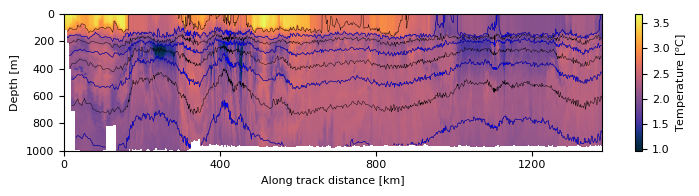

In [12]:
plt.figure(figsize=(7.5,2.))
ds_z_dist.CT.plot(cmap=cmo.thermal, rasterized=True, cbar_kwargs={'label': 'Temperature [$^o$C]'})
ds_z_dist.sigma0.plot.contour(levels=np.linspace(27.0, 27.9,10), colors='k', linewidths=0.3)
ds_z_dist.sigma0.plot.contour(levels=[27.1, 27.3, 27.5, 27.7], colors='b', linewidths=0.3)

plt.gca().invert_yaxis()

#plt.xticks([0, 4e5, 8e5, 12e5, 16e5], labels=[0, 400, 800, 1200, 1600])
plt.xticks([0, 4e5, 8e5, 12e5, ], labels=[0, 400, 800, 1200])
plt.xlabel('Along track distance [km]')
plt.ylabel('Depth [m]')

plt.tight_layout()

plt.savefig('figures/figure_section_panel1.pdf')

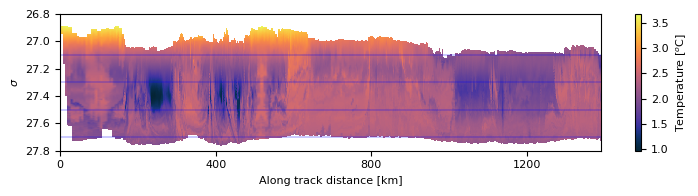

In [13]:
plt.figure(figsize=(7.5,2.))

ds_rho_dist.CT.plot(cmap=cmo.thermal, rasterized=True, cbar_kwargs={'label': 'Temperature [$^o$C]'})
plt.gca().invert_yaxis()
plt.hlines([27.1, 27.3, 27.5, 27.7],0, 1.7e6, 
          linewidths=0.3, colors='b')

#plt.xticks([0, 4e5, 8e5, 12e5, 16e5], labels=[0, 400, 800, 1200, 1600])
plt.xticks([0, 4e5, 8e5, 12e5, ], labels=[0, 400, 800, 1200])

plt.xlabel('Along track distance [km]')
plt.ylabel('$\sigma$')

plt.tight_layout()
plt.savefig('figures/figure_section_panel2.pdf')

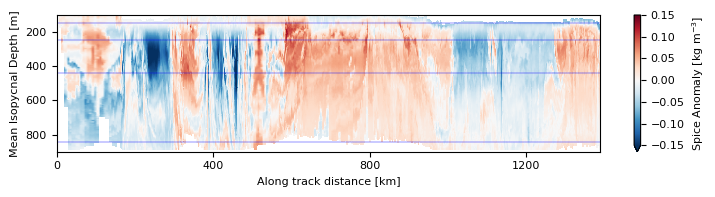

In [14]:
plt.figure(figsize=(7.5,2.))
Spice_on_Pmean.plot(vmin=-1.5e-1, rasterized=True, #interpolation= None,
                           cbar_kwargs={'label': 'Spice Anomaly [kg m$^{-3}$]'})
plt.hlines(Pmean_smooth.sel(rho_grid=[27.1, 27.3, 27.5, 27.7], method='nearest').values,0, 1.7e6, 
          linewidths=0.3, colors='b')
plt.gca().invert_yaxis()


#plt.xticks([0, 4e5, 8e5, 12e5, 16e5], labels=[0, 400, 800, 1200, 1600])
plt.xticks([0, 4e5, 8e5, 12e5, ], labels=[0, 400, 800, 1200])

plt.xlabel('Along track distance [km]')
plt.ylabel('Mean Isopycnal Depth [m]')
plt.ylim([900, 100])

plt.tight_layout()
plt.savefig('figures/figure_section_panel3.pdf')

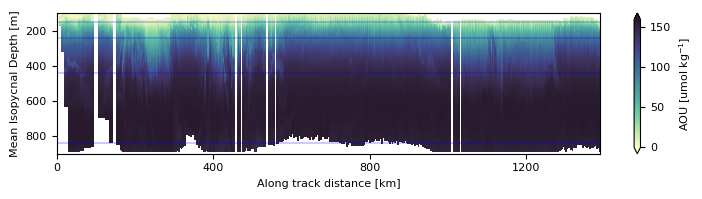

In [15]:
plt.figure(figsize=(7.5,2.))
AOU_on_Pmean.plot(vmin=0, vmax=160, rasterized=True, cmap=cmo.deep,#interpolation= None,
                           cbar_kwargs={'label': 'AOU [umol kg$^{-1}$]'})
#AOU_on_Pmean.plot.contour(levels=[50, 80, 110], colors='k', linewidths=0.3,) #interpolation= None,
#                           cbar_kwargs={'label': 'AOU [umol kg$^{-1}$]'})
                         
plt.hlines(Pmean_smooth.sel(rho_grid=[27.1, 27.3, 27.5, 27.7], method='nearest').values,0, 1.7e6, 
          linewidths=0.3, colors='b')
plt.gca().invert_yaxis()


#plt.xticks([0, 4e5, 8e5, 12e5, 16e5], labels=[0, 400, 800, 1200, 1600])
plt.xticks([0, 4e5, 8e5, 12e5, ], labels=[0, 400, 800, 1200])

plt.xlabel('Along track distance [km]')
plt.ylabel('Mean Isopycnal Depth [m]')

plt.ylim([900, 100])

plt.tight_layout()
plt.savefig('figures/figure_section_panel4.pdf')

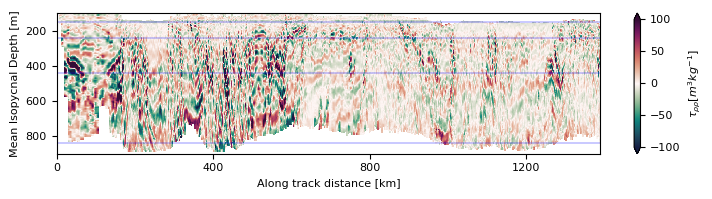

In [16]:
plt.figure(figsize=(7.5,2.))
Spice_rho_rho_on_Pmean.plot(vmin=-100, rasterized=True, cmap=cmo.curl,#interpolation= None,
                           cbar_kwargs={'label': r'$ \tau_{\rho \rho} [m ^3 kg ^{-1}]$'})
                         
plt.hlines(Pmean_smooth.sel(rho_grid=[27.1, 27.3, 27.5, 27.7], method='nearest').values,0, 1.7e6, 
          linewidths=0.3, colors='b')
plt.gca().invert_yaxis()


#plt.xticks([0, 4e5, 8e5, 12e5, 16e5], labels=[0, 400, 800, 1200, 1600])
plt.xticks([0, 4e5, 8e5, 12e5, ], labels=[0, 400, 800, 1200])

plt.xlabel('Along track distance [km]')
plt.ylabel('Mean Isopycnal Depth [m]')

plt.ylim([900, 100])

plt.tight_layout()
plt.savefig('figures/figure_section_panel5.pdf')